<a href="https://colab.research.google.com/github/ayulockin/deepgenerativemodeling/blob/master/Autoencoder_and_Variational_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setups, Imports and Installations

In [1]:
import tensorflow as tf
print(tf.__version__)

from tensorflow import keras
import tensorflow.keras.backend as K

2.2.0-rc2


In [0]:
%%capture
!pip install wandb

import wandb
from wandb.keras import WandbCallback

!wandb login 69f60a7711ce6b8bbae91ac6d15e45d6b1f1430e

In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

from tqdm.notebook import tqdm

# Let's use MNIST Dataset

In [4]:
from keras.datasets import mnist

# MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

image_size = x_train.shape[1]
original_dim = image_size * image_size
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

## Just dataset info
print("X_train: ", x_train.shape)
print("X_test: ", x_test.shape)

Using TensorFlow backend.


11493376/11490434 [==============================] - 1s 0us/step
X_train:  (60000, 784)
X_test:  (10000, 784)


# Autoencoder 

#### Model

In [0]:
class Autoencoder:
  def __init__(self, input_shape, original_dim, intermediate_dim, latent_space):
    self.input_shape = input_shape
    self.original_dim = original_dim
    self.intermediate_dim = intermediate_dim
    self.latent_space = latent_space
    
  def build_model(self):
    ## Initialize encoder model
    encoder_input, encoder_output = self.build_encoder()
    ## Initialize decoder model
    self.build_decoder()
    ## Join encoder and decoder
    decoder_output = self.decoder(encoder_output)
    ## Build autoencoder model
    return keras.models.Model(inputs=[encoder_input], outputs=[decoder_output])

  def build_encoder(self):
    ## ENCODER
    encoder_input = keras.layers.Input(shape=self.input_shape)
    x = keras.layers.Dense(self.intermediate_dim, activation='relu')(encoder_input)
    ## This is latent space
    encoder_output = keras.layers.Dense(self.latent_space)(x)
    encoder_output = keras.layers.LeakyReLU(0.3)(encoder_output)
    
    self.encoder =  keras.models.Model(inputs=[encoder_input], outputs=[encoder_output])
    return encoder_input, encoder_output

  def build_decoder(self):
    ## DECODER
    decoder_input = keras.layers.Input(shape=self.latent_space)
    x = keras.layers.Dense(self.intermediate_dim, activation='relu')(decoder_input)
    ## This is reconstruction
    decoder_output = keras.layers.Dense(self.original_dim, activation='sigmoid')(x)
    
    self.decoder = keras.models.Model(inputs=[decoder_input], outputs=[decoder_output])

In [0]:
keras.backend.clear_session()
ae = Autoencoder(input_shape=(784), 
                 original_dim=(784), 
                 intermediate_dim=512,
                 latent_space=2)
model = ae.build_model()

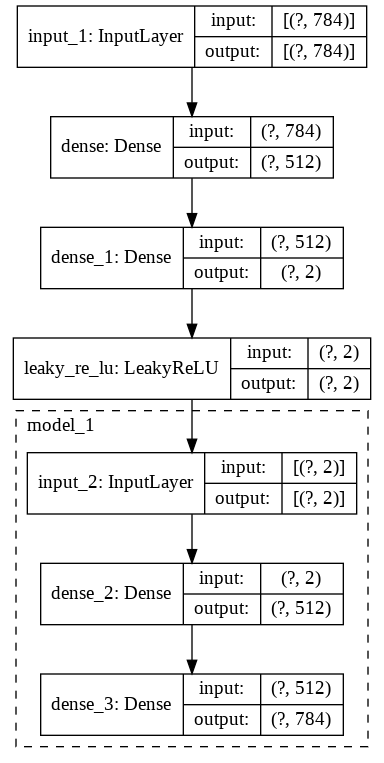

In [7]:
tf.keras.utils.plot_model(
      model, to_file='model.png', show_shapes=True, show_layer_names=True, expand_nested=True, dpi=96
    )

> *Must Read:* You may notice that we have three different models in the `Autoencoder`. They are `encoder` and `decoder`. Using `build_model` method you can build the entire `autoencoder model`. You will soon realize why I complicated things a bit. But it's always a good practice to wrap your model in a class. And have `intermediate` models if you have any. 

#### Compile

In [0]:
model.compile('adam', 'mean_squared_error')

#### WandB and Callbacks

In [0]:
class ReconstructionLogger(tf.keras.callbacks.Callback):
  def __init__(self, batch_size):
    self.batch_size = batch_size

    super(ReconstructionLogger, self).__init__()

  def on_epoch_end(self, logs, epoch):
    sample_images = x_test[:self.batch_size]
    
    images = []
    reconstructions = []
    
    for i in range(32):
        reconstruction = self.model.predict(sample_images[i].reshape((1,)+sample_images[i].shape))

        images.append(sample_images[i].reshape(28,28))
        reconstructions.append(reconstruction.reshape(28,28))

    wandb.log({"images": [wandb.Image(image)
                          for image in images]})
    wandb.log({"reconstructions": [wandb.Image(reconstruction)
                          for reconstruction in reconstructions]})

In [10]:
wandb.init(entity='ayush-thakur', project='keras-gan')

W&B Run: https://app.wandb.ai/ayush-thakur/keras-gan/runs/358ks2iw

In [0]:
config = wandb.config
config.batch_size = 32
config.epochs = 100

#### Train

In [12]:
_ = model.fit(x_train, 
              x_train, 
              epochs=config.epochs, 
              batch_size=config.batch_size,
              callbacks=[WandbCallback(),
                         ReconstructionLogger(config.batch_size)])

Epoch 1/100
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0534
Epoch 2/100
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0454
Epoch 3/100
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0438
Epoch 4/100
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0427
Epoch 5/100
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0420
Epoch 6/100
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0414
Epoch 7/100
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0409
Epoch 8/100
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0405
Epoch 9/100
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0402
Epoch 10/100
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0399
Epoch 11/100
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0396
Epoch 12/100
1875/1875 [==============================] - 5s 2ms/step - lo

#### Visualize **Latent Space**

In [13]:
## Number of examples
n_to_show = 5000

example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]
example_labels = y_test[example_idx]

latent_val1 = []
latent_val2 = []

for img, label in tqdm(zip(example_images, example_labels)):
  latent_val = ae.encoder.predict(img.reshape((1,)+img.shape))[0]
  latent_val1.append(latent_val[0])
  latent_val2.append(latent_val[1])

> Notice the use of `intermediate` model `encoder`.

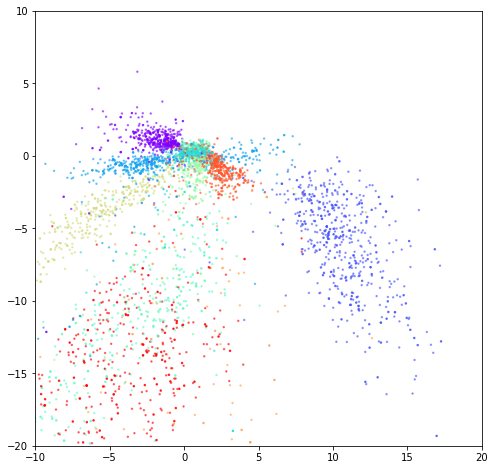

In [19]:
plt.figure(figsize=(8,8))
plt.scatter(latent_val1, latent_val2, cmap='rainbow' , c= example_labels
            , alpha=0.5, s=2);
plt.xlim(-10,20);
plt.ylim(-20,10);

In [0]:
## Log the same chart on W&B for future comparision. 
plt.figure(figsize=(8,8))
plt.scatter(latent_val1, latent_val2, 
            cmap='rainbow', 
            c=example_labels, 
            alpha=0.5, 
            s=2);
plt.xlim(-10,20);
plt.ylim(-20,10);
            
wandb.log({"ae_latent_space": plt})

> `xlim` and `ylim` limits may change depending on how the latent representation is formed. You may have to experiment with the limits but the provided limit hsould hopefully work just fine. 

# Variational Autoencoder

#### Model

In [0]:
class VariationalAutoencoder:
  def __init__(self, input_shape, original_dim, intermediate_dim, latent_dim):
    self.input_shape = input_shape
    self.original_dim = original_dim
    self.intermediate_dim = intermediate_dim
    self.latent_dim = latent_dim

  def build_model(self):
    # instantiate VAE model
    self.build_encoder()
    self.build_decoder()

    self.outputs = self.decoder(self.encoder(self.inputs)[2])

    self.vae = keras.models.Model(self.inputs, self.outputs, name='vae_mlp')
    self.add_loss()

    return self.vae

  def sampling(self, args):
      z_mean, z_log_var = args
      batch = K.shape(z_mean)[0]
      dim = K.int_shape(z_mean)[1]
      # by default, random_normal has mean = 0 and std = 1.0
      epsilon = K.random_normal(shape=(batch, dim))
      return z_mean + K.exp(0.5 * z_log_var) * epsilon

  def build_encoder(self):
    self.inputs = keras.layers.Input(shape=self.input_shape, name='encoder_input')
    x = keras.layers.Dense(self.intermediate_dim, activation='relu')(self.inputs)
    self.z_mean = keras.layers.Dense(self.latent_dim, name='z_mean')(x)
    self.z_log_var = keras.layers.Dense(self.latent_dim, name='z_log_var')(x)

    self.z = keras.layers.Lambda(self.sampling, output_shape=(self.latent_dim,), name='z')([self.z_mean, self.z_log_var])

    # instantiate encoder model
    self.encoder = keras.models.Model(self.inputs, [self.z_mean, self.z_log_var, self.z], name='encoder')


  def build_decoder(self):
    latent_inputs = keras.layers.Input(shape=(self.latent_dim,), name='z_sampling')
    x = keras.layers.Dense(self.intermediate_dim, activation='relu')(latent_inputs)
    outputs = keras.layers.Dense(self.original_dim, activation='sigmoid')(x)

    # instantiate decoder model
    self.decoder = keras.models.Model(latent_inputs, outputs, name='decoder')

  def add_loss(self):
    # VAE loss = mse_loss or xent_loss + kl_loss
    reconstruction_loss = keras.losses.mse(self.inputs, self.outputs)
    reconstruction_loss *= self.original_dim

    kl_loss = 1 + self.z_log_var - K.square(self.z_mean) - K.exp(self.z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5

    vae_loss = K.mean(reconstruction_loss + kl_loss)

    self.vae.add_loss(vae_loss)

In [0]:
keras.backend.clear_session()
vae = VariationalAutoencoder(input_shape=(784), 
                               original_dim=(784), 
                               intermediate_dim=512,
                               latent_dim=2)
model = vae.build_model()

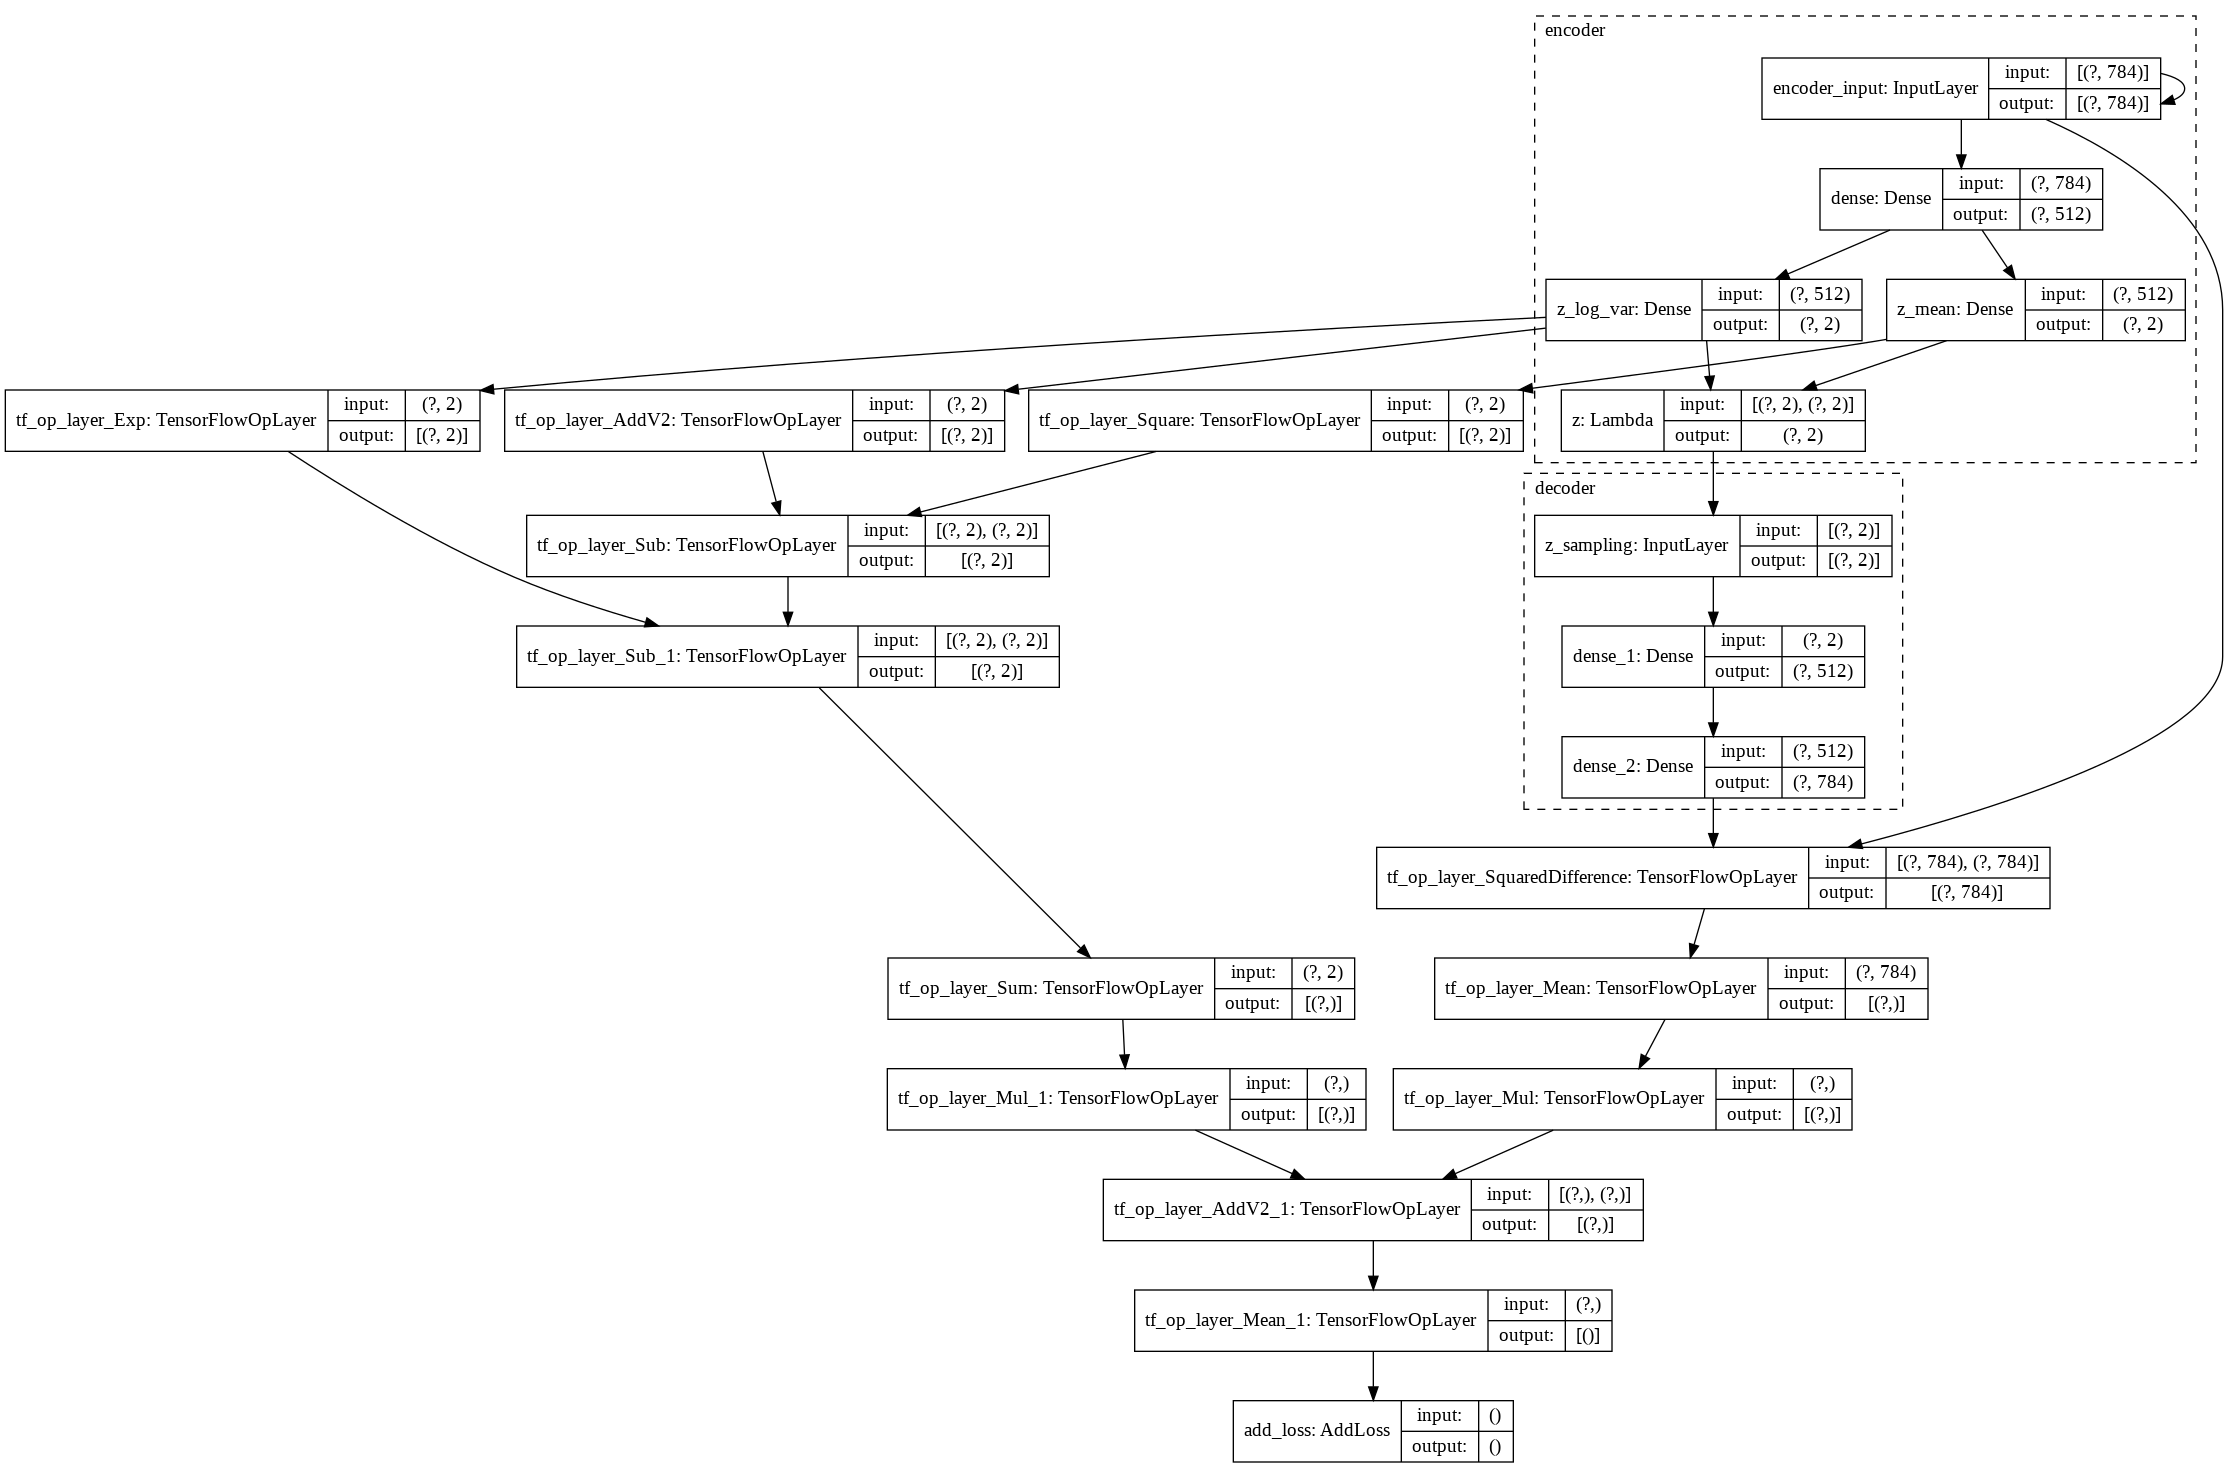

In [14]:
tf.keras.utils.plot_model(
      model, to_file='model.png', show_shapes=True, show_layer_names=True, expand_nested=True, dpi=96
    )

#### Compile

In [0]:
model.compile('adam')

#### WandB and Callbacks

In [0]:
class ReconstructionLogger(tf.keras.callbacks.Callback):
  def __init__(self, batch_size):
    self.batch_size = batch_size

    super(ReconstructionLogger, self).__init__()

  def on_epoch_end(self, logs, epoch):
    sample_images = x_test[:self.batch_size]
    
    images = []
    reconstructions = []
    
    for i in range(32):
        reconstruction = self.model.predict(sample_images[i].reshape((1,)+sample_images[i].shape))

        images.append(sample_images[i].reshape(28,28))
        reconstructions.append(reconstruction.reshape(28,28))

    wandb.log({"images": [wandb.Image(image)
                          for image in images]})
    wandb.log({"reconstructions": [wandb.Image(reconstruction)
                          for reconstruction in reconstructions]})

In [10]:
wandb.init(entity='ayush-thakur', project='keras-gan')

W&B Run: https://app.wandb.ai/ayush-thakur/keras-gan/runs/2eski4mn

In [0]:
config = wandb.config
config.batch_size = 32
config.epochs = 100

#### Train

In [0]:
# _ = model.fit(x_train, 
#               x_train, 
#               epochs=config.epochs, 
#               batch_size=config.batch_size,
#               callbacks=[WandbCallback(),
#                          ReconstructionLogger(config.batch_size)])

In [16]:
_ = model.fit(x_train, 
              x_train, 
              epochs=config.epochs, 
              batch_size=config.batch_size)

Epoch 1/100
1875/1875 [==============================] - 7s 4ms/step - loss: 45.7282
Epoch 2/100
1875/1875 [==============================] - 7s 4ms/step - loss: 41.9360
Epoch 3/100
1875/1875 [==============================] - 7s 4ms/step - loss: 41.0426
Epoch 4/100
1875/1875 [==============================] - 8s 4ms/step - loss: 40.4732
Epoch 5/100
1875/1875 [==============================] - 8s 4ms/step - loss: 40.0294
Epoch 6/100
1875/1875 [==============================] - 7s 4ms/step - loss: 39.6717
Epoch 7/100
1875/1875 [==============================] - 7s 4ms/step - loss: 39.3761
Epoch 8/100
1875/1875 [==============================] - 7s 4ms/step - loss: 39.1173
Epoch 9/100
1875/1875 [==============================] - 7s 4ms/step - loss: 38.8496
Epoch 10/100
1875/1875 [==============================] - 7s 4ms/step - loss: 38.6521
Epoch 11/100
1875/1875 [==============================] - 7s 4ms/step - loss: 38.4523
Epoch 12/100
1875/1875 [==============================] - 7s 4m

#### Visualize **Latent Space**

In [17]:
## Number of examples
n_to_show = 5000

example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]
example_labels = y_test[example_idx]

latent_val1 = []
latent_val2 = []

for img, label in tqdm(zip(example_images, example_labels)):
  latent_val = vae.encoder.predict(img.reshape((1,)+img.shape))[2][0]
  latent_val1.append(latent_val[0])
  latent_val2.append(latent_val[1])

> Notice the use of `intermediate` model `encoder`.

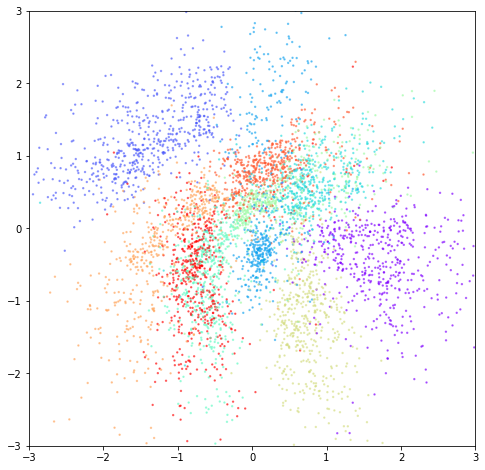

In [18]:
plt.figure(figsize=(8,8))
plt.scatter(latent_val1, latent_val2, cmap='rainbow' , c= example_labels
            , alpha=0.5, s=2);
plt.xlim(-3,3);
plt.ylim(-3,3);

In [0]:
plt.figure(figsize=(8,8))
plt.scatter(latent_val1, latent_val2, 
            cmap='rainbow', 
            c=example_labels, 
            alpha=0.5, 
            s=2);

plt.xlim(-3,3);
plt.ylim(-3,3);

wandb.log({"vae_latent_space": plt})

> Note how the `xlim` and `ylim` were not actually necesarry by commenting it out and then running the cell. The latent points are bounded around a region.  

# Generate New Digits

In [48]:
generated_images = []

for i in tqdm(range(32)):
  ## Sample from normal distribution 
  l_sample = np.random.normal(size=2)
  l_sample = l_sample.reshape((1,)+l_sample.shape)
  ## Pass the sample to the decoder
  gen_img = vae.decoder(l_sample)
  gen_img = gen_img.numpy()
  generated_images.append(gen_img.reshape(28,28))

wandb.log({"generated_images": [wandb.Image(image) for image in generated_images]})